In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
import math
# import PIL
plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
df = pd.read_sql("""
select experiments.*, queue_depth_histograms.*
from queue_depth_histograms
inner join experiments on queue_depth_histograms.experiment_id = experiments.id
where experiments.note in ('postcard', 'postcard-ecn', 'postcard-20000')
  and experiments.algorithm in ('reno')
  and action = 'drop'
  --and experiments.max_queue_depth_cells = 20000
""", con=con)
df

,index,action,algorithm,filename,id,max_queue_depth_bytes,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter,experiment_id,queue_depth_packets,count
0,None,drop,reno,results/86652240-8f13-11ea-8dea-0cc47aaaaa10/t...,86652240-8f13-11ea-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,2,1ms,postcard-ecn,2020-05-05 14:01:05.199801,False,1.0,bspang,86652240-8f13-11ea-8dea-0cc47aaaaa10,0.017778,19
1,None,drop,reno,results/86652240-8f13-11ea-8dea-0cc47aaaaa10/t...,86652240-8f13-11ea-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,2,1ms,postcard-ecn,2020-05-05 14:01:05.199801,False,1.0,bspang,86652240-8f13-11ea-8dea-0cc47aaaaa10,0.026667,2
2,None,drop,reno,results/86652240-8f13-11ea-8dea-0cc47aaaaa10/t...,86652240-8f13-11ea-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,2,1ms,postcard-ecn,2020-05-05 14:01:05.199801,False,1.0,bspang,86652240-8f13-11ea-8dea-0cc47aaaaa10,0.062222,1
3,None,drop,reno,results/86652240-8f13-11ea-8dea-0cc47aaaaa10/t...,86652240-8f13-11ea-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,2,1ms,postcard-ecn,2020-05-05 14:01:05.199801,False,1.0,bspang,86652240-8f13-11ea-8dea-0cc47aaaaa10,0.213333,1
4,None,drop,reno,results/86652240-8f13-11ea-8dea-0cc47aaaaa10/t...,86652240-8f13-11ea-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,2,1ms,postcard-ecn,2020-05-05 14:01:05.199801,False,1.0,bspang,86652240-8f13-11ea-8dea-0cc47aaaaa10,0.364444,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31976,None,drop,reno,results/2c6e596e-90d0-11ea-8dea-0cc47aaaaa10/t...,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,1000000,12500,111.111111,9000,32,1ms,postcard,2020-05-07 19:04:00.335258,False,1.0,bspang,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,113.653333,2
31977,None,drop,reno,results/2c6e596e-90d0-11ea-8dea-0cc47aaaaa10/t...,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,1000000,12500,111.111111,9000,32,1ms,postcard,2020-05-07 19:04:00.335258,False,1.0,bspang,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,113.697778,1
31978,None,drop,reno,results/2c6e596e-90d0-11ea-8dea-0cc47aaaaa10/t...,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,1000000,12500,111.111111,9000,32,1ms,postcard,2020-05-07 19:04:00.335258,False,1.0,bspang,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,113.724444,1
31979,None,drop,reno,results/2c6e596e-90d0-11ea-8dea-0cc47aaaaa10/t...,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,1000000,12500,111.111111,9000,32,1ms,postcard,2020-05-07 19:04:00.335258,False,1.0,bspang,2c6e596e-90d0-11ea-8dea-0cc47aaaaa10,113.742222,1


In [4]:
df['rounded_queue_depth_packets'] = np.floor(df['queue_depth_packets'])
bdp = 166.66

Reno - drop - queue len: 45


TypeError: style_axis() got an unexpected keyword argument 'tight_layout'

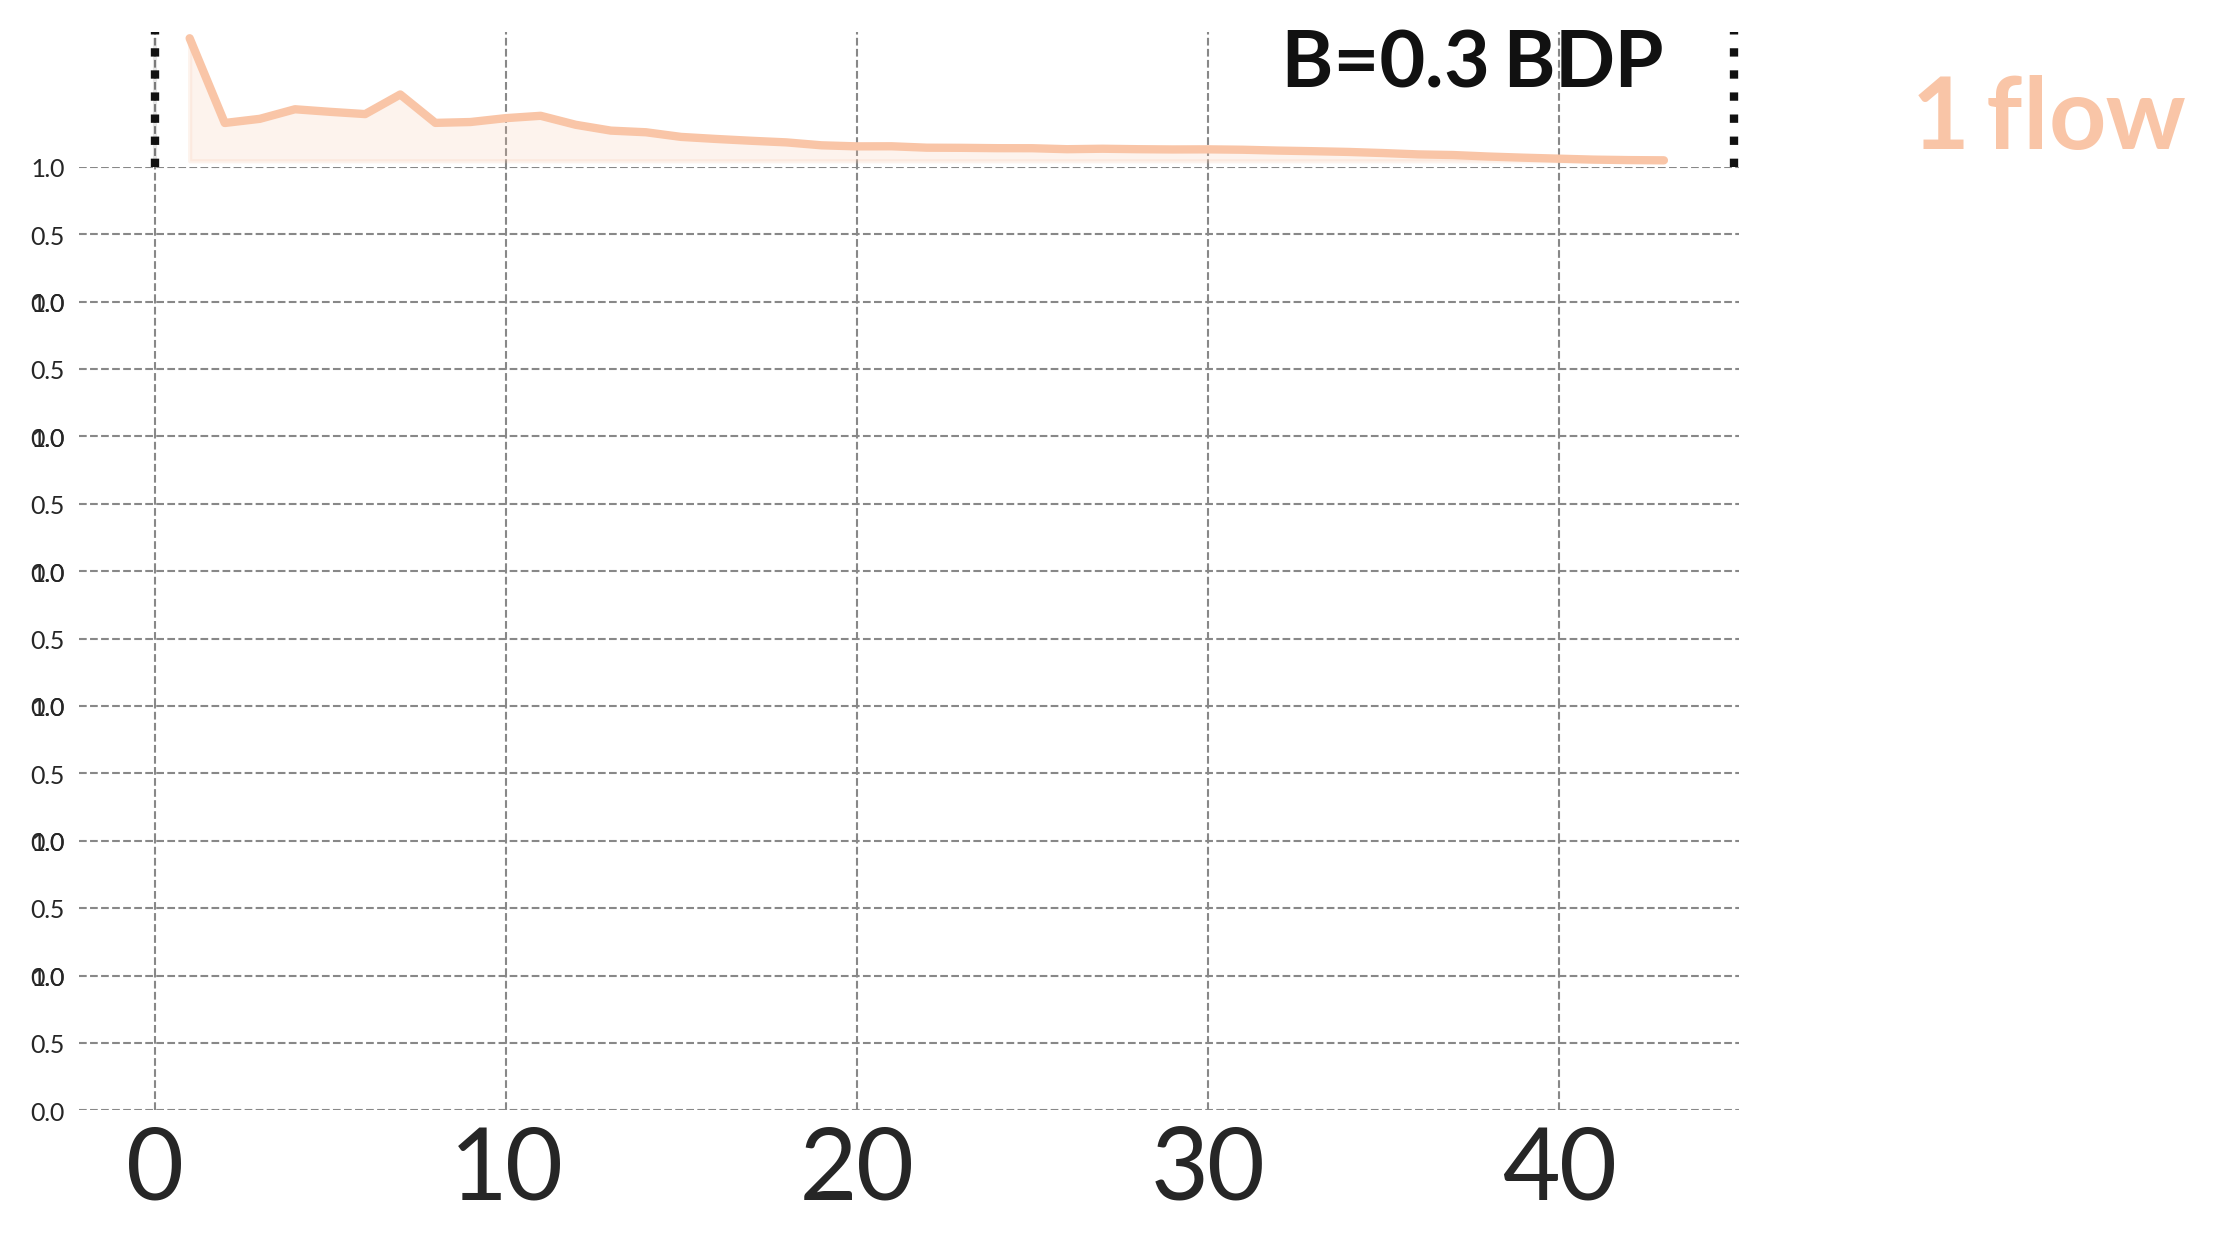

In [8]:
for key in ['axes.titlesize', 'axes.labelsize', 'legend.fontsize',
            'xtick.labelsize', 'font.size']:
    matplotlib.rcParams[key] = 24

for (alg,queue_len,action),qdf in df.groupby(['algorithm', 'max_queue_depth_packets', 'action']):
    queue_len = np.ceil(queue_len)
    
    if queue_len < 10: continue
    #if queue_len < bdp-1: continue
    if queue_len > bdp: continue
        
    unique_num_flows = len(pd.unique(qdf.num_flows))
    print("%s - %s - queue len: %d"%(alg.title(),action,queue_len))
    
    data = qdf.groupby(['num_flows', 'rounded_queue_depth_packets'], as_index=False).sum()
        
    ind = 1 
    lines = []
    labels = []
    fig, ax = plt.subplots(unique_num_flows, 1, sharex=True, figsize=(width, width*2/3))
    for num_flows, nfdf in data.groupby(['num_flows']):
        nfdf = nfdf[nfdf['count'] > 50]
        
        color = plorts.palettes.neon((ind+1.5) / (unique_num_flows+1.5))
        
        plt.sca(ax[ind-1])
        plt.subplots_adjust(hspace=0)
        
        ax[ind-1].plot(nfdf['rounded_queue_depth_packets'],
                       nfdf['count'], label = num_flows,
                       color=color)

        xmin = max(queue_len - 2 * bdp / math.sqrt(num_flows),0)
        ax[ind-1].fill_between(nfdf[nfdf['rounded_queue_depth_packets']>xmin]['rounded_queue_depth_packets'],
                             nfdf[nfdf['rounded_queue_depth_packets']>xmin]['count'], 0,
                             color=color,#plorts.palettes.neon(ind/unique_num_flows-0.5/unique_num_flows),
                             alpha=0.2)
        
        ax[ind-1].axvline(x = xmin, linestyle=":", color='#111111')
        ax[ind-1].fill_between([0, xmin],
                             [nfdf['count'].max(), nfdf['count'].max()], 0,
                             color='black',
                             alpha=0.1)

        
        ax[ind-1].axvline(x=queue_len, color='#111111', linestyle=":")
        if ind == 1:
            plt.text(queue_len-2, 0.6*nfdf['count'].max(), 'B=%.1f BDP'%(queue_len/bdp),
                     fontweight='bold', color='#111111', ha='right', fontsize=19)
            
        if queue_len < 0.9*bdp:
            if num_flows == 1:
                label = '1 flow'
            else:
                label = '{} flows'.format(num_flows)
        else:
            label = str(num_flows)
        plt.text(queue_len + 5, 0.1*nfdf['count'].max(), label,
                 color=color, fontweight='bold')

        
        if queue_len == 166 and num_flows == 64:
            plt.text(10, 0.3*nfdf['count'].max(), "Unnecessary queue",
                     fontweight='bold', color='black')

        ax[ind-1].axes.yaxis.set_ticks([])

        plorts.style_axis(tight_layout=False)
        ax[ind-1].grid(axis='x')

        line, label = ax[ind-1].get_legend_handles_labels()
        lines += line
        labels += label

        ind += 1 
    ax[0].set_ylabel("Queue depth distribution")
    
    plt.xlabel("Queue Depth (packets)")
    
    plt.axis(xmin=0,xmax=185,ymin=0)
        
    plorts.savefig('../figures/queue_len_distributions/%s_%s_%d_subplots.jpg'%(alg,action,queue_len))
    plt.show()

In [ ]:
ecn = pd.read_sql("""
select experiments.*, queue_depth_histograms.*
from queue_depth_histograms
inner join experiments on queue_depth_histograms.experiment_id = experiments.id
where experiments.note in ('postcard', 'postcard-ecn', 'postcard-20000')
  and experiments.algorithm in ('reno')
  and action = 'ecn'
  and experiments.max_queue_depth_cells = 15000
""", con=con)
ecn

In [78]:
other_algs = pd.read_sql("""
select experiments.*, queue_depth_histograms.*
from queue_depth_histograms
inner join experiments on queue_depth_histograms.experiment_id = experiments.id
where experiments.note in ('postcard', 'postcard-ecn', 'postcard-20000', 'bbr2')
  and experiments.algorithm in ('cubic', 'scalable', 'bbr', 'bbr2')
  and action = 'drop'
  and experiments.max_queue_depth_cells in (15000,20000)
""", con=con)
other_algs

,index,action,algorithm,filename,id,max_queue_depth_bytes,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter,experiment_id,queue_depth_packets,count
0,None,drop,bbr,results/8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10/t...,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,1600000,20000,177.777778,9000,64,1ms,postcard,2020-05-04 11:32:03.716129,False,1.0,bspang,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,177.484444,62
1,None,drop,bbr,results/8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10/t...,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,1600000,20000,177.777778,9000,64,1ms,postcard,2020-05-04 11:32:03.716129,False,1.0,bspang,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,177.493333,5
2,None,drop,bbr,results/8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10/t...,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,1600000,20000,177.777778,9000,64,1ms,postcard,2020-05-04 11:32:03.716129,False,1.0,bspang,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,177.502222,108
3,None,drop,bbr,results/8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10/t...,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,1600000,20000,177.777778,9000,64,1ms,postcard,2020-05-04 11:32:03.716129,False,1.0,bspang,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,177.511111,32
4,None,drop,bbr,results/8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10/t...,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,1600000,20000,177.777778,9000,64,1ms,postcard,2020-05-04 11:32:03.716129,False,1.0,bspang,8a4a8d02-8e35-11ea-8dea-0cc47aaaaa10,177.520000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44626,None,drop,bbr2,results/d98808b8-88e9-11eb-8dea-0cc47aaaaa10/t...,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,128,1ms,bbr2,2021-03-19 12:32:36.296779,False,1.0,bspang,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,136.293333,2
44627,None,drop,bbr2,results/d98808b8-88e9-11eb-8dea-0cc47aaaaa10/t...,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,128,1ms,bbr2,2021-03-19 12:32:36.296779,False,1.0,bspang,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,136.302222,1
44628,None,drop,bbr2,results/d98808b8-88e9-11eb-8dea-0cc47aaaaa10/t...,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,128,1ms,bbr2,2021-03-19 12:32:36.296779,False,1.0,bspang,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,136.320000,1
44629,None,drop,bbr2,results/d98808b8-88e9-11eb-8dea-0cc47aaaaa10/t...,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,1200000,15000,133.333333,9000,128,1ms,bbr2,2021-03-19 12:32:36.296779,False,1.0,bspang,d98808b8-88e9-11eb-8dea-0cc47aaaaa10,136.462222,1


Bbr - drop - queue len: 134


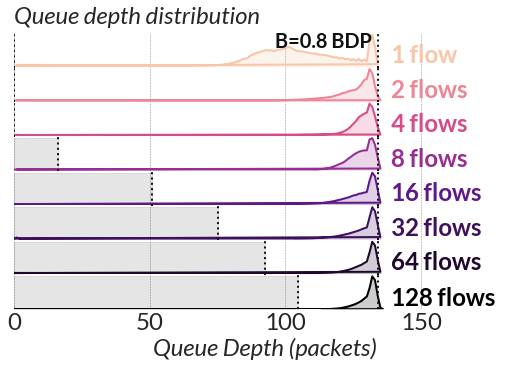

Bbr2 - drop - queue len: 134


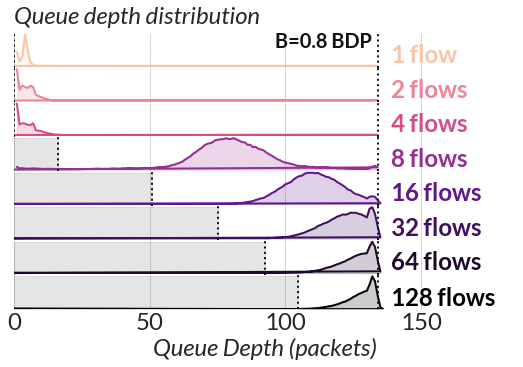

Cubic - drop - queue len: 134


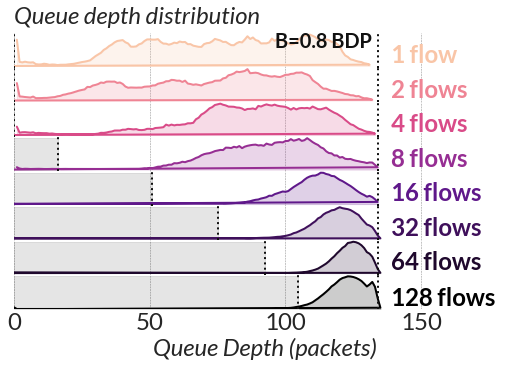

Scalable - drop - queue len: 134


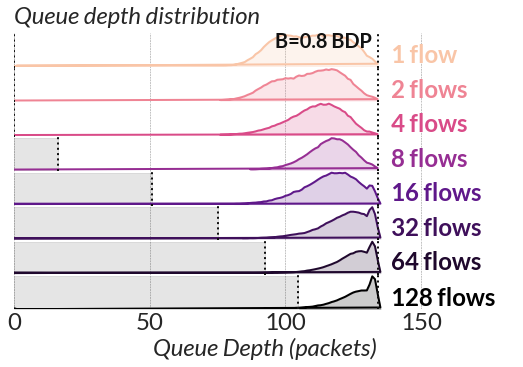

In [84]:
from importlib import reload
reload(plorts)

for key in ['axes.titlesize', 'axes.labelsize', 'legend.fontsize',
            'xtick.labelsize', 'font.size']:
    matplotlib.rcParams[key] = 24

other_algs['rounded_queue_depth_packets'] = np.floor(other_algs['queue_depth_packets'])    
for (alg,queue_len,action),qdf in other_algs.groupby(['algorithm', 'max_queue_depth_packets', 'action']):
    queue_len = np.ceil(queue_len)
    
    if queue_len < 10: continue
    #if queue_len < bdp-1: continue
    if queue_len > bdp: continue
        
    unique_num_flows = len(pd.unique(qdf.num_flows))
    print("%s - %s - queue len: %d"%(alg.title(),action,queue_len))
    
    data = qdf.groupby(['num_flows', 'rounded_queue_depth_packets'], as_index=False).sum()
        
    ind = 1 
    lines = []
    labels = []
    fig, ax = plt.subplots(unique_num_flows, 1, sharex=True, figsize=(width, width*2/3))
    for num_flows, nfdf in data.groupby(['num_flows']):
        nfdf = nfdf[nfdf['count'] > 50]
        
        color = plorts.palettes.neon((ind+1.5) / (unique_num_flows+1.5))
        
        plt.sca(ax[ind-1])
        plt.subplots_adjust(hspace=0.)
        
        ax[ind-1].plot(np.append(nfdf['rounded_queue_depth_packets'], 0),
                       np.append(nfdf['count'], 0), label = num_flows,
                       color=color)

        xmin = max(queue_len - 2 * bdp / math.sqrt(num_flows),0)
        ax[ind-1].fill_between(nfdf[nfdf['rounded_queue_depth_packets']>xmin]['rounded_queue_depth_packets'],
                             nfdf[nfdf['rounded_queue_depth_packets']>xmin]['count'], 0,
                             color=color,#plorts.palettes.neon(ind/unique_num_flows-0.5/unique_num_flows),
                             alpha=0.2)
        
        ax[ind-1].axvline(x = xmin, linestyle=":", color='#111111')
        ax[ind-1].fill_between([0, xmin],
                             [nfdf['count'].max(), nfdf['count'].max()], 0,
                             color='black',
                             alpha=0.1)

        
        ax[ind-1].axvline(x=queue_len, color='#111111', linestyle=":")
        if ind == 1:
            plt.text(queue_len-2, 0.6*nfdf['count'].max(), 'B=%.1f BDP'%(queue_len/bdp),
                     fontweight='bold', color='#111111', ha='right', fontsize=20)
            
        if queue_len < 0.9*bdp:
            if num_flows == 1:
                label = '1 flow'
            else:
                label = '{} flows'.format(num_flows)
        else:
            label = str(num_flows)
        plt.text(queue_len + 5, 0.1*nfdf['count'].max(), label,
                 color=color, fontweight='bold')

        
        if queue_len == 166 and num_flows == 64:
            plt.text(10, 0.3*nfdf['count'].max(), "Unnecessary queue",
                     fontweight='bold', color='black')

        ax[ind-1].axes.yaxis.set_ticks([])

        plorts.style_axis(tight_layout=False)
        ax[ind-1].grid(axis='x')

        line, label = ax[ind-1].get_legend_handles_labels()
        lines += line
        labels += label

        ind += 1 
    ax[0].set_ylabel("Queue depth distribution")
    
    plt.xlabel("Queue Depth (packets)")
    
    plt.axis(xmin=0,xmax=185,ymin=0)
        
    plorts.savefig('../figures/queue_len_distributions/%s_%s_%d_subplots.jpg'%(alg,action,queue_len))
    plt.show()

In [13]:
bbr = pd.read_sql("""
select experiments.*, queue_depth_histograms.*
from queue_depth_histograms
inner join experiments on queue_depth_histograms.experiment_id = experiments.id
where experiments.note in ('postcard', 'postcard-ecn', 'postcard-20000')
  and experiments.algorithm in ('bbr')
  and action = 'drop'
  and max_queue_depth_cells in (15000, 20000)
  --and experiments.max_queue_depth_cells = 20000
""", con=con)

Bbr - drop - queue len: 134


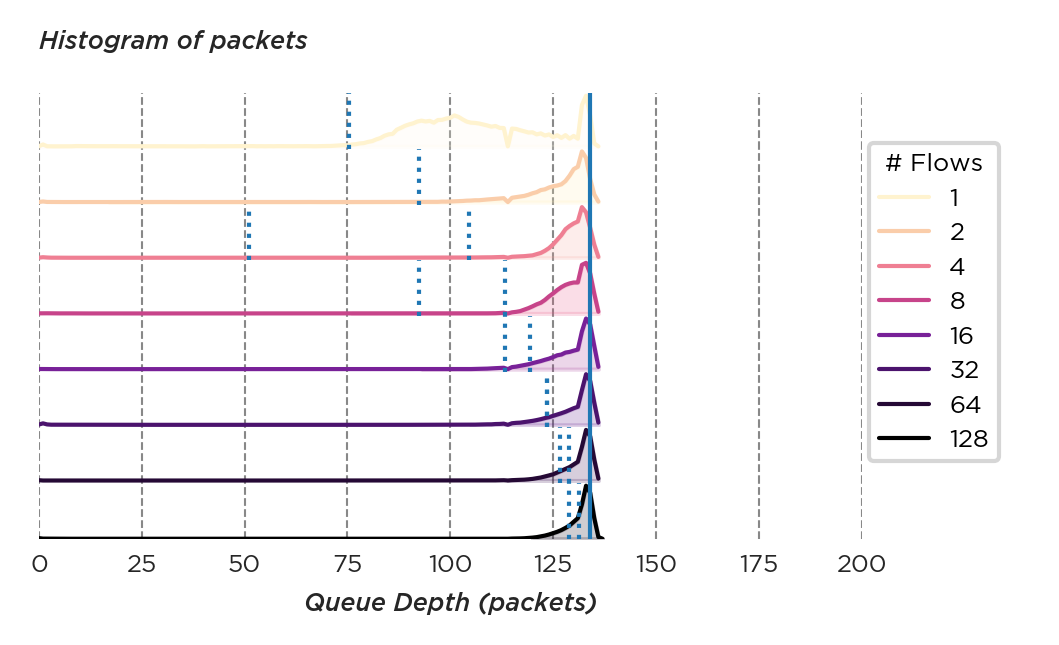

Bbr - drop - queue len: 178


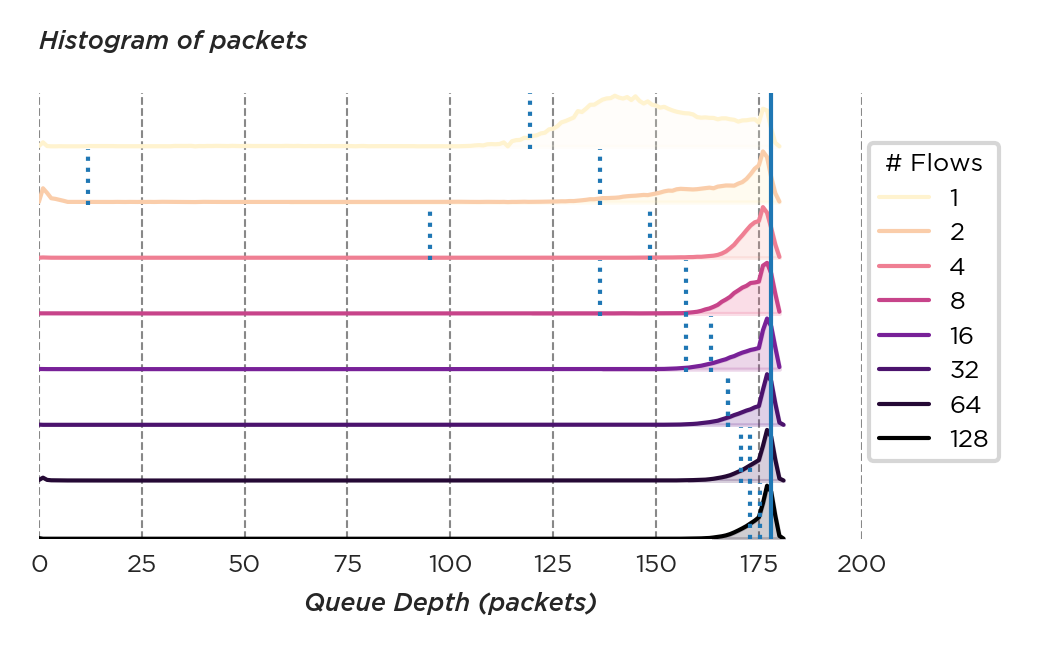

In [16]:
alg = 'bbr'
bbr['rounded_queue_depth_packets'] = bbr['queue_depth_packets'].round()
for (queue_len,action),qdf in bbr.groupby(['max_queue_depth_packets', 'action']):
    queue_len = np.ceil(queue_len)
    unique_num_flows = len(pd.unique(qdf.num_flows))
    print("%s - %s - queue len: %d"%(alg.title(),action,queue_len))
    
    data = qdf.groupby(['num_flows', 'rounded_queue_depth_packets'], as_index=False).sum()
        
    ind = 1 
    lines = []
    labels = []
    f, ax = plt.subplots(unique_num_flows,1,sharex=True,figsize=(width, width*2/3))
    for num_flows, nfdf in data.groupby(['num_flows']):

        plt.sca(ax[ind-1])
        ax[ind-1].plot(nfdf['rounded_queue_depth_packets'],
                       nfdf['count'], label = num_flows,
                       color=plorts.palettes.neon(ind / unique_num_flows))

        xmin = queue_len - bdp / math.sqrt(num_flows)
        ax[ind-1].fill_between(nfdf[nfdf['rounded_queue_depth_packets']>xmin]['rounded_queue_depth_packets'],
                             nfdf[nfdf['rounded_queue_depth_packets']>xmin]['count'], 0,
                             color=plorts.palettes.neon(ind/unique_num_flows-0.5/unique_num_flows),
                             alpha=0.2)
        ax[ind-1].axvline(x=queue_len)
        xmin = queue_len - 1 * bdp / math.sqrt(8*num_flows)
        ax[ind-1].axvline(x = xmin, linestyle=":")
        
        xmin = queue_len - 2 * bdp / num_flows
        ax[ind-1].axvline(x = xmin, linestyle=":")


        ax[ind-1].axes.yaxis.set_ticks([])

        plorts.style_axis()
        ax[ind-1].grid(axis='x')

        line, label = ax[ind-1].get_legend_handles_labels()
        lines += line
        labels += label

        ind += 1 
    ax[0].set_ylabel("Histogram of packets")
    plt.figlegend(lines, labels, 
             loc='center left', title="# Flows", bbox_to_anchor=(1, 0.6))
    
#     plt.title("%s - %s - queue len: %d"%(alg.title(),action,queue_len))
    plt.xlabel("Queue Depth (packets)")
    
    
    if queue_len < 200 and action=="drop":
        plt.axis(xmin=0,xmax=200,ymin=0)
    else:
        plt.axis(xmin=0,xmax=250,ymin=0)
        
    plorts.savefig('../figures/queue_len_distributions/%s_%s_%d_subplots.jpg'%(alg,action,queue_len))
    plt.show()